## An End-to-End Transformer Model for Crowd Localization

This notebook includes my analysis and implementation details of the paper titled "An End-to-End Transformer Model for Crowd Localization" from my own perspective.

### Metadata of the Paper

| Field      | Value                                     |
|------------|-------------------------------------------|
| Title      | An end-to-end transformer model for crowd localization |
| Author(s)  | Liang, Dingkang<br>Xu, Wei<br>Bai, Xiang  |
| Book Title | Computer Vision--ECCV 2022: 17th European Conference, Tel Aviv, Israel, October 23--27, 2022, Proceedings, Part I |
| Pages      | 38--54                                    |
| Year       | 2022                                      |
| Organization | Springer                                 |

### The Aim of This Study

Liang et al. (2022) suggests that <u>predicting head positions for crowd localization</u> is a more practical and advanced task than simply counting the number of people in a crowd. The authors propose a new method called CLTR, which is an end-to-end Crowd Localization Transformer that solves this task in a regression-based paradigm. This approach treats crowd localization as a direct set prediction problem, <u>utilizing extracted features and trainable embeddings as inputs to the transformer-decoder</u>. To generate more reasonable matching results and reduce ambiguous points, the authors introduce a <u>KMO-based Hungarian matcher</u> that considers nearby context as auxiliary matching cost. The effectiveness of this proposed method is evaluated on five datasets with various data settings, and it achieves the best localization performance on the NWPU-Crowd, UCF-QNRF, and ShanghaiTech Part A datasets.

<div style="text-align: center;">
    <img src="./images/1.PNG" alt="Image" />
</div>

### Implementation Details

The proposed approach by authors, "An End-to-End Transformer Model for Crowd Localization," aims to <u>predict crowd instances directly without the need for additional pre-processing or post-processing steps</u>. The implementation consists of a CNN-based backbone, a transformer encoder, a transformer decoder, and a KMO-based matcher.

<div style="text-align: center;">
    <img src="./images/2.PNG" alt="Image" />
</div>


* Below are the key components and steps involved in the implementation:

    * __CNN-based Backbone__: The first step is to extract feature maps from the input image. In this study, the ResNet50 architecture is utilized as the backbone network for its strong feature extraction capabilities.

    * __Feature Map Flattening__: The extracted feature maps are flattened into a 1D sequence, which is then enriched with positional embedding (Fp) to provide spatial information.

    * __Transformer Encoder__: The flattened sequence with positional embedding (Fp) is passed through a transformer encoder layer, resulting in encoded features (Fe). To reduce the channel dimension of the extracted feature maps, a 1x1 convolution is applied.

    * __Transformer Decoder__: The transformer decoder layers take the trainable head queries (Qh) and the encoded features (Fe) as input. Through cross-attention mechanisms, the decoder layers interact with each other, generating the decoded embedding (Fd), which contains both point (person's head) and category information.

    * __Point Regression and Classification Heads__: The decoded embeddings (Fd) are subsequently decoupled into point coordinates and confidence scores using a point regression head and a classification head, respectively. This enables precise localization of crowd instances and classification into specific categories.

    * __KMO-based Matcher__: During the model training process, it is necessary to match the predictions with ground truth (GT) by employing a one-to-one correspondence. Unmatched predicted points are considered as belonging to the "background" class.

    * __Data Augmentation__: To enhance the model's robustness and generalization, various data augmentation techniques are employed during training. These include random cropping, random scaling, and horizontal flipping of the training data.

    * __Optimizer and Learning Rate__: The Adam optimizer with a learning rate of 1e-4 is utilized to optimize the model parameters.

    * __Datasets__: The proposed model is evaluated on three benchmark datasets: UCF-QNRF, JHU-Crowd++, and NWPU-Crowd.

### Additional Keynotes

* The authors point out that regression-based methods, which predict coordinates directly, are more straightforward than detection-based and map-based methods. One advantage of these methods is that they can be trained end-to-end, without the need for preprocessing steps such as creating pseudo ground truth boxes or maps. Moreover, they do not rely on complex multi-scale fusion mechanisms to produce high-quality feature maps.

* The proposed method in this study is inspired from the paper "End-to-end object detection with transformers". This method provides accurate object detection results in a simpler and more effective way. However, the authors note that it cannot be directly applied to crowd localization due to the intrinsic limitations of the matcher. Specifically, the key component in DETR (the method used in the "End-to-end object detection with transformers" paper) is the L1-based Hungarian matcher, which measures the L1 distance of bounding boxes with class confidence to match the prediction-ground truth bounding box pairs, showing superior performance in object detection. However, in crowd datasets, no bounding boxes are given, and for crowd localization, L1 distance can easily lead to ambiguous matching in the point-to-point pairs. Crowd images only contain one category (heads), and the dense heads usually have similar textures, reporting close confidence, which can confuse the matcher. Therefore, the authors introduce a new k-nearest neighbors (KNN) matching objective named KMO as an auxiliary matching cost. The KMO-based Hungarian considers the context from nearby heads, which helps to reduce the ambiguous points and generate more reasonable matching results.

### Benchmark Results

* As part of the CMP719 lecture project, the following tables have been utilized as benchmarks with the aim of achieving comparable results to those presented in the referenced paper. These tables provide an achieved results of the crowd counting performance based on the NWPU and UCF-QNRF datasets by authors.

<div style="text-align: center;">
    <img src="./images/3.PNG" alt="Image" width="50%"/>
</div>

<div style="text-align: center;">
    <img src="./images/4.PNG" alt="Image" width="50%"/>
</div>

### Implementation

* In this section, the architecture will be implemented.

##### Create an Environment and Install Dependencies

* First create the virtual environment and install dependencies on it (preventing from dependency conflicts with previously installed packages). Use in terminals.

```
        python -m venv venv
        venv\Scripts\activate
```
* When the environment is activated, create a requirements.txt file and inside it, copy and paste the libraries shown below. Save the file.

```     
        matplotlib
        numpy
        pandas
        scipy
        pillow
        opencv-python
        tensorboard
        torch 
        torchvision 
        torchaudio
        h5py
        imageio
```

* Run the query to install dependencies into created environment.
```
        python -m pip install --upgrade pip
        python -m pip install -r requirements.txt
```

* After completion of the installing process, install the dataset from this [link](https://onedrive.live.com/?authkey=%21ABXuzFNW_VWzQCo&id=255D1679C866D64F%21605&cid=255D1679C866D64F&parId=root&parQt=sharedby&o=OneUp). It is important to note that this is an 21GB file so that it takes minutes or hours depending on the internet connection.

In [1]:
# load utilities
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import h5py
import os
import glob
import cv2

##### Read, Explore and Visualize the Dataset

* Visualize an image.

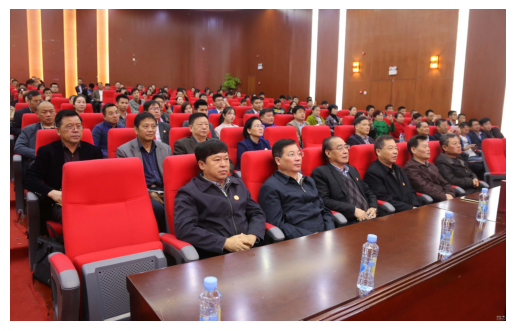

In [2]:
# Read a sample and from the dataset and visualize
image_path = './data/NWPU_CLTR/images_2048/0004.jpg'

# Open the image file
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

* Visualize the corresponding marks that depicts the heads of the each person.

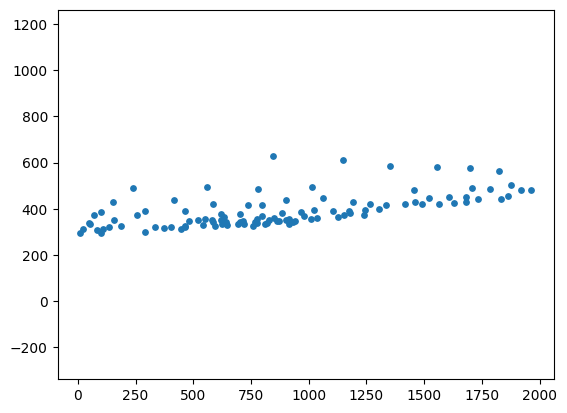

In [3]:
# Path to the .npy file
npy_file_path = "./data/NWPU_CLTR/gt_npydata_2048/0004.npy"

# Load the .npy file
data = np.load(npy_file_path)

# Extract x and y coordinates
x_coords = data[:, 0]
y_coords = data[:, 1]

# Visualize the coordinates as points
plt.scatter(x_coords, y_coords, s=15)
plt.axis("equal")
plt.show()

* Now draw both to validate the labels matches or not with the corresponding image.

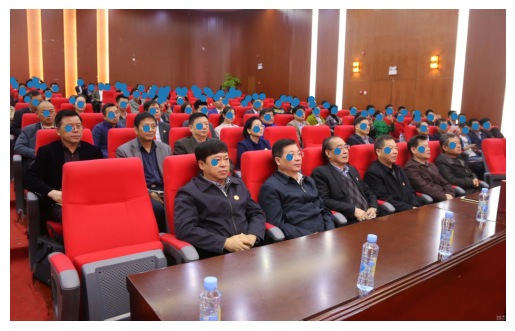

In [5]:
# visualize another sample from dataset
image_path = "data/NWPU_CLTR/images_2048/0004.jpg"
npy_file_path = "./data/NWPU_CLTR/gt_npydata_2048/0004.npy"

# Load the image using PIL
image = Image.open(image_path)

# Convert the image to RGB format if it's not already
image = image.convert("RGB")

# Load the .npy file
data = np.load(npy_file_path)

# Extract x and y coordinates
x_coords = data[:, 0]
y_coords = data[:, 1]

# Visualize the image and points
plt.imshow(image)
plt.scatter(x_coords, y_coords, s=15)
plt.axis('off')
plt.show()

* Check another image.

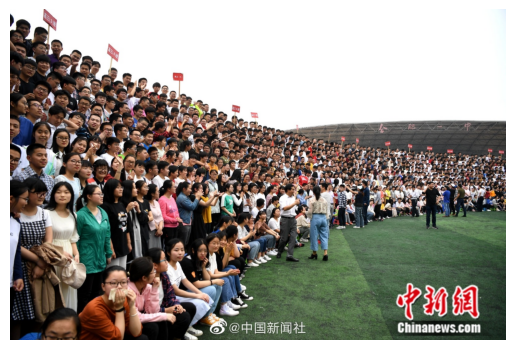

In [12]:
# Read a sample and from the dataset and visualize
image_path = './data/NWPU_CLTR/images_2048/0013.jpg'

# Open the image file
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

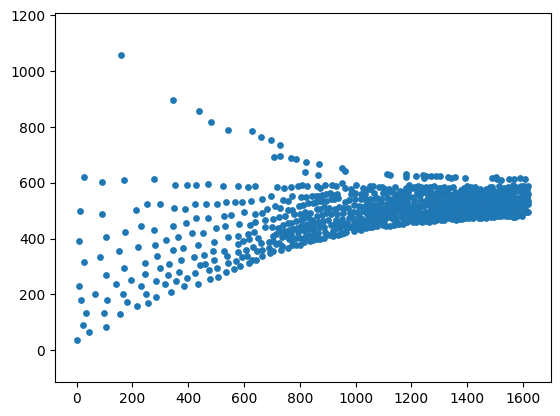

In [13]:
# Path to the .npy file
npy_file_path = "./data/NWPU_CLTR/gt_npydata_2048/0013.npy"

# Load the .npy file
data = np.load(npy_file_path)

# Extract x and y coordinates
x_coords = data[:, 0]
y_coords = data[:, 1]

# Visualize the coordinates as points
plt.scatter(x_coords, y_coords, s=15)
plt.axis("equal")
plt.show()

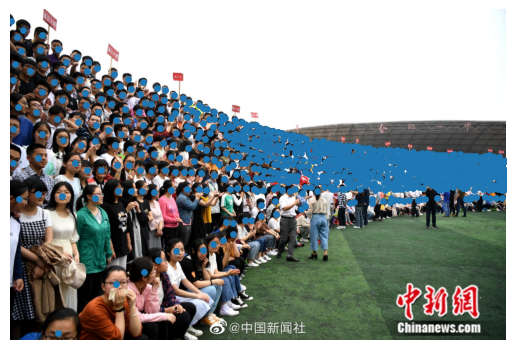

In [11]:
# visualize another sample from dataset
image_path = "data/NWPU_CLTR/images_2048/0013.jpg"
npy_file_path = "./data/NWPU_CLTR/gt_npydata_2048/0013.npy"

# Load the image using PIL
image = Image.open(image_path)

# Convert the image to RGB format if it's not already
image = image.convert("RGB")

# Load the .npy file
data = np.load(npy_file_path)

# Extract x and y coordinates
x_coords = data[:, 0]
y_coords = data[:, 1]

# Visualize the image and points
plt.imshow(image)
plt.scatter(x_coords, y_coords, s=15)
plt.axis('off')
plt.show()

##### Data Preparation

* Now prepare the dataset. 

* Following code block process image and ground truth data for a training and validation set. It reads image paths from text files, loads the corresponding images, and performs various operations such as resizing, converting color modes, and manipulating pixel values based on the ground truth data. The processed data is then saved as HDF5 files, which contain the modified images and associated annotations.

* To prevent an excessive amount of information on the screen, not all steps are printed. However, to ensure that the process is progressing correctly, a message is printed every 200 iterations.

In [9]:
# preparation of the data
data_path = './data/NWPU_CLTR'

def process_training_set():
    train_list = open("./data/NWPU_list/train.txt", "r").readlines()

    for i in range(len(train_list)):
        fname = train_list[i].split(' ')[0] + '.jpg'
        img_path = os.path.join(data_path, 'images_2048', fname)

        img = cv2.imread(img_path)
        Img_data_pil = Image.open(img_path).convert('RGB')

        k = np.zeros((img.shape[0], img.shape[1]))
        point_map = np.zeros((img.shape[0], img.shape[1], 3)) + 255
        mat_path = img_path.replace('images', 'gt_npydata').replace('jpg', 'npy')

        with open(mat_path, 'rb') as outfile:
            gt = np.load(outfile).tolist()

        for i in range(len(gt)):
            if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1
                point_map = cv2.circle(point_map, (int(gt[i][0]), int(gt[i][1])), 5, (0, 0, 0), -1)

        kpoint = k.astype(np.uint8)

        with h5py.File(img_path.replace('images_2048', 'gt_detr_map').replace('jpg', 'h5'), 'w') as hf:
            hf.create_dataset('kpoint', data=kpoint)
            hf.create_dataset('image', data=Img_data_pil)
        
        if i % 200 == 0:
            print("training_part", img_path)

def process_validation_set():
    val_list = open("./data/NWPU_list/val.txt", "r").readlines()

    for i in range(len(val_list)):
        fname = val_list[i].split(' ')[0] + '.jpg'
        img_path = os.path.join(data_path, 'images', fname)

        img = cv2.imread(img_path)
        image_s = cv2.imread(img_path.replace('images', 'images_2048'))
        Img_data_pil = Image.open(img_path).convert('RGB')

        if img.shape[1] >= img.shape[0] and img.shape[1] >= 4096:
            rate1 = 4096.0 / img.shape[1]
            img = cv2.resize(img, (0, 0), fx=rate1, fy=rate1, interpolation=cv2.INTER_CUBIC)
            Img_data_pil = Img_data_pil.resize((img.shape[1], img.shape[0]), Image.ANTIALIAS)
        elif img.shape[0] >= img.shape[1] and img.shape[0] >= 4096:
            rate1 = 4096.0 / img.shape[0]
            img = cv2.resize(img, (0, 0), fx=rate1, fy=rate1, interpolation=cv2.INTER_CUBIC)
            Img_data_pil = Img_data_pil.resize((img.shape[1], img.shape[0]), Image.ANTIALIAS)

        rate = img.shape[0] / image_s.shape[0]

        point_map = np.zeros((img.shape[0], img.shape[1]))
        mat_path = img_path.replace('images', 'gt_npydata_2048').replace('jpg', 'npy')

        with open(mat_path, 'rb') as outfile:
            gt = (np.load(outfile) * rate).tolist()

        for i in range(len(gt)):
            if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
                point_map[int(gt[i][1]), int(gt[i][0])] = 1

        kpoint = point_map.astype(np.uint8)

        with h5py.File(img_path.replace('images', 'gt_detr_map').replace('jpg', 'h5'), 'w') as hf:
            hf.create_dataset('kpoint', data=kpoint)
            hf.create_dataset('image', data=Img_data_pil)

        if i % 200 == 0:
            print("val part", img_path)

# Process the training set
process_training_set()

# Process the validation set
process_validation_set()


training_part ./data/NWPU_CLTR/images_2048/0113.jpg
training_part ./data/NWPU_CLTR/images_2048/0250.jpg
training_part ./data/NWPU_CLTR/images_2048/0389.jpg
training_part ./data/NWPU_CLTR/images_2048/0401.jpg
training_part ./data/NWPU_CLTR/images_2048/0679.jpg
training_part ./data/NWPU_CLTR/images_2048/1131.jpg
training_part ./data/NWPU_CLTR/images_2048/1217.jpg
training_part ./data/NWPU_CLTR/images_2048/1271.jpg
training_part ./data/NWPU_CLTR/images_2048/1280.jpg
training_part ./data/NWPU_CLTR/images_2048/1367.jpg
training_part ./data/NWPU_CLTR/images_2048/1401.jpg
training_part ./data/NWPU_CLTR/images_2048/1565.jpg
training_part ./data/NWPU_CLTR/images_2048/1661.jpg
training_part ./data/NWPU_CLTR/images_2048/2009.jpg
training_part ./data/NWPU_CLTR/images_2048/2510.jpg
training_part ./data/NWPU_CLTR/images_2048/2620.jpg
training_part ./data/NWPU_CLTR/images_2048/2671.jpg
training_part ./data/NWPU_CLTR/images_2048/2716.jpg
training_part ./data/NWPU_CLTR/images_2048/2904.jpg



* The followind code block prepares the data for the NWPU dataset. It creates the npydata directory if it doesn't exist and attempts to read the train.txt and val.txt files. It constructs the root path for the gt_detr_map directory and checks if it exists. If the root path exists, it generates lists of image file paths for training and validation data. These paths are created by combining the root path with the filenames from the text files. The generated lists are then saved as numpy arrays in the npydata directory.

In [10]:
# preparation of the data
nwpu_root = './data/NWPU_CLTR'

if not os.path.exists('./npydata'):
    os.makedirs('./npydata')

try:
    train_list = open("./data/NWPU_list/train.txt", "r").readlines()
    val_list = open("./data/NWPU_list/val.txt", "r").readlines()
    root = os.path.join(nwpu_root, 'gt_detr_map')

    if not os.path.exists(root):
        print("The NWPU dataset path is not found.")
    else:
        train_img_list = [os.path.join(root, item.split(' ')[0] + '.jpg') for item in train_list]
        val_img_list = [os.path.join(root, item.split(' ')[0] + '.jpg') for item in val_list]

        np.save('./npydata/nwpu_train.npy', train_img_list)
        np.save('./npydata/nwpu_val.npy', val_img_list)

        print("Generate NWPU image list successfully", len(train_img_list), len(val_img_list))
except:
    print("The NWPU dataset path is not found.")

Generate NWPU image list successfully 3109 500


#### Building the Architecutre

##### Attention Mechanism

* The `attention mechanism` is a computational mechanism commonly used in deep learning models, particularly in transformer architectures. It allows the model to focus on different parts of the input sequence or feature representation while performing computations. In the context of natural language processing tasks, such as machine translation or text summarization, the attention mechanism enables the model to selectively attend to relevant words or phrases during the encoding and decoding processes. By assigning different weights to different parts of the input, the attention mechanism allows the model to capture context and dependencies effectively, enhancing its ability to generate accurate and contextually informed predictions.

* The following code block defines a MultiheadAttention class and a corresponding multi_head_attention_forward function. These components are used to implement the multi-head attention mechanism, which is a key building block in transformer-based models.

* The MultiheadAttention class represents the multi-head attention module. It inherits from the torch.nn.Module class and encapsulates the functionality required for attention computations. The class constructor initializes the parameters and weights of the attention mechanism, while the forward method performs the forward pass of the attention computation, taking inputs such as query, key, and value tensors. The attention mechanism computes attention weights, applies masking if necessary, and generates the final attention output.

* The multi_head_attention_forward function is defined separately from the class but serves a similar purpose. It handles the core computations of the attention mechanism, such as scaling the query tensor, computing attention weights, and applying masks. This function is called within the forward method of the MultiheadAttention class to perform the attention computations. The function returns the attention output tensor and, if specified, the averaged attention weights over the heads.

* It is crucial to acknowledge that my implementation heavily relies on the [Transformer-MM-Explainability repository](https://github.com/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP/clip/auxilary.py) by hila-chefer as a reference point.

In [17]:
from torch import nn

import torch
from torch import Tensor
from torch.nn.init import constant_
from torch.nn.modules.module import Module

import warnings
import math

from torch import _VF
from torch._jit_internal import Optional, Tuple
from torch.overrides import has_torch_function, handle_torch_function
from torch.nn.modules.linear import Linear as _LinearWithBias

Tensor = torch.Tensor

from torch.nn.functional import linear, pad, softmax, dropout


class MultiheadAttention(Module):
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None,
                vdim=None):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads

        self.out_proj = _LinearWithBias(vdim, vdim)

        self.in_proj_bias = None
        self.in_proj_weight = None
        self.bias_k = self.bias_v = None
        self.q_proj_weight = None
        self.k_proj_weight = None
        self.v_proj_weight = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        constant_(self.out_proj.bias, 0.)

    def __setstate__(self, state):
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):
        if not self._qkv_same_embed_dim:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight, out_dim=self.vdim)
        else:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, out_dim=self.vdim)


def multi_head_attention_forward(query: Tensor,
                                key: Tensor,
                                value: Tensor,
                                embed_dim_to_check: int,
                                num_heads: int,
                                in_proj_weight: Tensor,
                                in_proj_bias: Tensor,
                                bias_k: Optional[Tensor],
                                bias_v: Optional[Tensor],
                                add_zero_attn: bool,
                                dropout_p: float,
                                out_proj_weight: Tensor,
                                out_proj_bias: Tensor,
                                training: bool = True,
                                key_padding_mask: Optional[Tensor] = None,
                                need_weights: bool = True,
                                attn_mask: Optional[Tensor] = None,
                                use_separate_proj_weight: bool = False,
                                q_proj_weight: Optional[Tensor] = None,
                                k_proj_weight: Optional[Tensor] = None,
                                v_proj_weight: Optional[Tensor] = None,
                                static_k: Optional[Tensor] = None,
                                static_v: Optional[Tensor] = None,
                                out_dim: Optional[Tensor] = None
                                ) -> Tuple[Tensor, Optional[Tensor]]:
    
    if not torch.jit.is_scripting():
        tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v,
                    out_proj_weight, out_proj_bias)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                multi_head_attention_forward, tens_ops, query, key, value,
                embed_dim_to_check, num_heads, in_proj_weight, in_proj_bias,
                bias_k, bias_v, add_zero_attn, dropout_p, out_proj_weight,
                out_proj_bias, training=training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask,
                use_separate_proj_weight=use_separate_proj_weight,
                q_proj_weight=q_proj_weight, k_proj_weight=k_proj_weight,
                v_proj_weight=v_proj_weight, static_k=static_k, static_v=static_v)
    tgt_len, bsz, embed_dim = query.size()

    head_dim = embed_dim // num_heads
    v_head_dim = out_dim // num_heads
    scaling = float(head_dim) ** -0.5

    q = query * scaling
    k = key
    v = value

    if attn_mask is not None:
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)

        if attn_mask.dim() == 2:
            attn_mask = attn_mask.unsqueeze(0)
            if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 2D attn_mask is not correct.')
        elif attn_mask.dim() == 3:
            if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 3D attn_mask is not correct.')
        else:
            raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))

    # convert ByteTensor key_padding_mask to bool
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn(
            "Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)

    if bias_k is not None and bias_v is not None:
        if static_k is None and static_v is None:
            k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = pad(key_padding_mask, (0, 1))

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if k is not None:
        k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    if v is not None:
        v = v.contiguous().view(-1, bsz * num_heads, v_head_dim).transpose(0, 1)

    if static_k is not None:
        k = static_k

    if static_v is not None:
        v = static_v

    src_len = k.size(1)

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2))

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_output_weights.masked_fill_(attn_mask, float('-inf'))
        else:
            attn_output_weights += attn_mask

    if key_padding_mask is not None:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        attn_output_weights = attn_output_weights.masked_fill(
            key_padding_mask.unsqueeze(1).unsqueeze(2),
            float('-inf'),
        )
        attn_output_weights = attn_output_weights.view(bsz * num_heads, tgt_len, src_len)

    attn_output_weights = softmax(
        attn_output_weights, dim=-1)
    attn_output_weights = dropout(attn_output_weights, p=dropout_p, training=training)

    attn_output = torch.bmm(attn_output_weights, v)
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, out_dim)
    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)

    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None

### Utilities

* Utility functions: These are the functions for bounding boxes. The functions is can be cloned from the DETR paper implementations (This is the different paper from my project). (It is important to note that the authors emphasizes the DETR shows terrible performance on crowd localization so that they modified this architecture. Therefore, i clone some components from the DETR paper which authors directly used these components from the DETR. I focused on the modified components as the authors did).

* Write the following commands to get this files:

    * create an empty folder called util in this directory -> `mkdir ./util`
    
    * change directory -> `cd util`

    * download box_ops.py -> `wget -O box_ops.py https://raw.githubusercontent.com/facebookresearch/detr/main/util/box_ops.py`
    
    * download box_ops.py -> `wget -O misc.py https://raw.githubusercontent.com/dk-liang/CLTR/main/util/misc.py`

### Positional Encoding

* `Positional encoding` is a technique used in the transformer model to incorporate spatial information into the input sequence. By adding sinusoidal functions of different frequencies and phases to the input embeddings, the positional encoding provides the model with a sense of relative and absolute positions of elements in the image. This allows the Transformer model to leverage positional information during the self-attention mechanism, enabling it to reason about spatial relationships and improve performance.

* The following code block defines two classes, PositionEmbeddingSine and PositionEmbeddingLearned, which are used to incorporate position information into the input sequence in computer vision tasks.

* The `PositionEmbeddingSine` class implements a positional encoding technique inspired by the "Attention is all you need" paper. It takes a tensor as input and generates positional embeddings by performing cumulative sums along the height and width dimensions. These embeddings are then divided by a temperature factor and transformed using sine and cosine functions. The resulting embeddings are concatenated and returned.

* The `PositionEmbeddingLearned` class, on the other hand, learns absolute position embeddings. It uses two embedding layers (nn.Embedding) to generate position embeddings based on the row and column indices of the input tensor. The embeddings are concatenated and returned.

* The `build_position_encoding` function is responsible for constructing the appropriate positional encoding based on the provided arguments. It determines the number of steps for the positional encoding based on the hidden dimension size and selects the appropriate positional encoding class (PositionEmbeddingSine or PositionEmbeddingLearned) based on the chosen position embedding type.

In [29]:
import math

import torch
from torch import nn

class PositionEmbeddingSine(nn.Module):

    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, tensor_list: NestedTensor):
        x = tensor_list.tensors
        mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos


class PositionEmbeddingLearned(nn.Module):

    def __init__(self, num_pos_feats=256):
        super().__init__()
        self.row_embed = nn.Embedding(50, num_pos_feats)
        self.col_embed = nn.Embedding(50, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list: NestedTensor):
        x = tensor_list.tensors
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)
        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        return pos


def build_position_encoding(args):
    N_steps = args.hidden_dim // 2
    if args.position_embedding in ('v2', 'sine'):
        # TODO find a better way of exposing other arguments
        position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
    elif args.position_embedding in ('v3', 'learned'):
        position_embedding = PositionEmbeddingLearned(N_steps)
    else:
        raise ValueError(f"not supported {args.position_embedding}")

    return position_embedding

### Backbone Architecture

* `Backbone architecture` is used as a main feature extraction component of a deep learning model. The backbone architecture is responsible for processing input images and extracting high-level features that can be used for various computer vision tasks such as estimating head position in this study.

* The `ResNet` architecture is an important backbone in computer vision due to its ability to address the degradation problem in deep neural networks. By introducing residual connections, ResNet allows information to bypass certain layers and facilitates the learning of residual mappings. This enables the network to capture richer representations and achieve improved accuracy.

* The following code block defines a ResNet-based backbone architecture for a computer vision model. It includes the implementation of a fixed batch normalization layer, the base class for the backbone, the ResNet backbone itself, a module for combining the backbone with position encoding, and a function to build the complete backbone architecture. The ResNet backbone is initialized with specified parameters, and the intermediate feature maps and position encodings are extracted during forward propagation. This backbone architecture forms a crucial component for feature extraction in computer vision tasks and enables the model to learn rich representations from input data.

In [21]:
from typing import Dict, List

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision.models._utils import IntermediateLayerGetter

class FrozenBatchNorm2d(torch.nn.Module):
    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                            missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias


class BackboneBase(nn.Module):
    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels

    def forward(self, tensor_list: NestedTensor):
        xs = self.body(tensor_list.tensors)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            m = tensor_list.mask
            assert m is not None
            mask = F.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            out[name] = NestedTensor(x, mask)
        return out


class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""

    def __init__(self, name: str,
                train_backbone: bool,
                return_interm_layers: bool,
                dilation: bool):
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=True, norm_layer=FrozenBatchNorm2d)
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)


class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)

    def forward(self, tensor_list: NestedTensor):
        xs = self[0](tensor_list)
        out: List[NestedTensor] = []
        pos = []
        for name, x in xs.items():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))

        return out, pos


def build_backbone(args):
    position_embedding = build_position_encoding(args)
    train_backbone = args.lr_backbone > 0
    return_interm_layers = args.masks
    backbone = Backbone(args.backbone, train_backbone, return_interm_layers, args.dilation)
    model = Joiner(backbone, position_embedding)
    model.num_channels = backbone.num_channels
    return model

### Hungarian Matcher

* The following code block defines a class called `HungarianMatcher` and a function called `build_matcher`.

* The HungarianMatcher class is responsible for computing an assignment between the targets and predictions of a network. It uses the Hungarian algorithm, implemented by the linear_sum_assignment function from the SciPy library, to find the optimal assignment that minimizes the matching cost. The matching cost is a combination of classification error, L1 error of bounding box coordinates, and GIoU (Generalized Intersection over Union) loss of the bounding box.

* The forward method of the HungarianMatcher class takes the outputs of the network (classification logits and predicted box coordinates) and the target ground-truth information. It performs the matching by computing the cost for each possible assignment and applying the Hungarian algorithm to find the optimal assignment. The method returns a list of tuples, where each tuple contains the indices of the selected predictions and the corresponding selected targets.

* The build_matcher function creates an instance of the HungarianMatcher class by passing the required arguments, including the relative weights for different costs (classification, bounding box coordinates, and GIoU). It returns the created HungarianMatcher object.

In [22]:
import torch
from scipy.optimize import linear_sum_assignment
from torch import nn
import numpy as np
import scipy.spatial
class HungarianMatcher(nn.Module):
    def __init__(self, args, cost_class: float = 1, cost_point: float = 1, cost_giou: float = 1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_point = cost_point
        self.args = args
        assert cost_class != 0 or cost_point != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs["pred_logits"].shape[:2]

        out_prob = outputs["pred_logits"].flatten(0, 1).sigmoid()  # [batch_size * num_queries, num_classes]


        out_point = outputs["pred_points"].flatten(0, 1)
        tgt_point = torch.cat([v["points"] for v in targets])
        tgt_ids = torch.cat([v["labels"] for v in targets])

        # Compute the classification cost.
        alpha = 0.25
        gamma = 2.0
        neg_cost_class = (1 - alpha) * (out_prob ** gamma) * (-(1 - out_prob + 1e-8).log())
        pos_cost_class = alpha * ((1 - out_prob) ** gamma) * (-(out_prob + 1e-8).log())
        cost_class = pos_cost_class[:, tgt_ids] - neg_cost_class[:, tgt_ids]

        cost_point = torch.cdist(out_point, tgt_point.cuda(), p=1)

        C = self.cost_class * cost_class + self.cost_point * cost_point
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["points"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]


def build_matcher(args):
    return HungarianMatcher(args, cost_class=args.set_cost_class, cost_point=args.set_cost_point, cost_giou=args.set_cost_giou)

### Segmentation

* The code snippet defines a class called DETRsegm that extends the nn.Module class in PyTorch. This class implements a segmentation model based on the DETR architecture. The model takes input samples and passes them through a backbone network, transformer, and various heads to predict class labels, bounding box coordinates, and `segmentation` masks. The forward method performs the forward pass of the model, extracting features from the backbone, applying attention mechanisms, and generating the final predictions. The code also includes other helper classes and functions for post-processing the model outputs, calculating loss functions such as dice loss and sigmoid focal loss, and converting the model's predictions to the final panoptic result format.

* Segmentation script as same architecture as with DETR paper. So that this functions can be cloned from the DETR paper implementations (This is the different paper from my project).

    * `mkdir ./models`

    * `cd models`

    * download box_ops.py -> `wget -O segmentation.py https://raw.githubusercontent.com/facebookresearch/detr/main/models/segmentation.py`

### Transformer Based Model

* The following code block defines classes and functions for a Transformer-based model. It includes the implementation of a multi-layer perceptron (MLP), the generation of sine embeddings for position encoding, and the main Transformer model comprising an encoder and decoder. The encoder and decoder consist of multiple layers of self-attention and cross-attention mechanisms, with residual connections and layer normalization. The model takes input tensors, applies various projections and transformations, and produces the final output. The code demonstrates how the Transformer model can be used for tasks involving sequence-to-sequence mapping or object detection.

* Conditional DETR script as same architecture as with DETR paper. So that this functions can be cloned from the DETR paper implementations (This is the different paper from my project).

    * download transformer.py -> `wget -O segmentation.py https://github.com/dk-liang/CLTR/blob/main/Networks/CDETR/transformer.py`

### Conditional DETR

* The provided code block includes the implementation of the `Conditional DETR` model for object detection. It imports various modules and functions from the PyTorch library and custom utility modules. The ConditionalDETR class represents the main model, which consists of a backbone network, transformer architecture, and prediction heads for class and point regression. The SetCriterion class computes the loss for the Conditional DETR model by performing the Hungarian matching between ground truth points and model predictions. The PostProcess class converts the model's output into the expected format for evaluation or visualization. Overall, this code implements the key components required for object detection using Conditional DETR.

* It is crucial to acknowledge that following implementation heavily relies on the [DETR](https://github.com/facebookresearch/detr) by facebookresearch as a reference point.

In [26]:
import math

import torch
import torch.nn.functional as F
from torch import nn

class ConditionalDETR(nn.Module):

    def __init__(self, backbone, transformer, num_classes, num_queries, channel_point, aux_loss=False):

        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes)
        self.point_embed = MLP(hidden_dim, hidden_dim, channel_point, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.backbone = backbone
        self.aux_loss = aux_loss

        prior_prob = 0.01
        bias_value = -math.log((1 - prior_prob) / prior_prob)
        self.class_embed.bias.data = torch.ones(num_classes) * bias_value

        nn.init.constant_(self.point_embed.layers[-1].weight.data, 0)
        nn.init.constant_(self.point_embed.layers[-1].bias.data, 0)

    def forward(self, samples: NestedTensor):
   
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.backbone(samples)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs, reference = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])

        reference_before_sigmoid = inverse_sigmoid(reference)
        outputs_coords = []
        for lvl in range(hs.shape[0]):
            tmp = self.point_embed(hs[lvl])
            tmp[..., :2] += reference_before_sigmoid
            outputs_coord = tmp.sigmoid()
            outputs_coords.append(outputs_coord)
        outputs_coord = torch.stack(outputs_coords)

        outputs_class = self.class_embed(hs)
        out = {'pred_logits': outputs_class[-1], 'pred_points': outputs_coord[-1]}
        if self.aux_loss:
            out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):

        return [{'pred_logits': a, 'pred_points': b}
                for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]


class SetCriterion(nn.Module):

    def __init__(self, num_classes, matcher, weight_dict, focal_alpha, losses):

        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.losses = losses
        self.focal_alpha = focal_alpha

    def loss_labels(self, outputs, targets, indices, num_points, log=True):

        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)]).cuda()
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        target_classes_onehot = torch.zeros([src_logits.shape[0], src_logits.shape[1], src_logits.shape[2] + 1],
                                            dtype=src_logits.dtype, layout=src_logits.layout, device=src_logits.device)
        target_classes_onehot.scatter_(2, target_classes.unsqueeze(-1), 1)

        target_classes_onehot = target_classes_onehot[:, :, :-1]
        loss_ce = sigmoid_focal_loss(src_logits, target_classes_onehot, num_points, alpha=self.focal_alpha, gamma=2) * \
                  src_logits.shape[1]
        losses = {'loss_ce': loss_ce}

        if log:
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_points):

        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_points(self, outputs, targets, indices, num_points):
        assert 'pred_points' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_points = outputs['pred_points'][idx]
        target_points = torch.cat([t['points'][i] for t, (_, i) in zip(targets, indices)], dim=0).cuda()

        loss_point = F.l1_loss(src_points, target_points, reduction='none')

        losses = {}
        losses['loss_point'] = loss_point.sum() / num_points
        return losses

    def loss_masks(self, outputs, targets, indices, num_points):
        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_points),
            "loss_dice": dice_loss(src_masks, target_masks, num_points),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_points, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'points': self.loss_points,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_points, **kwargs)

    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}
        indices = self.matcher(outputs_without_aux, targets)
        num_points = sum(len(t["labels"]) for t in targets)
        num_points = torch.as_tensor([num_points], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_points)
        num_points = torch.clamp(num_points / get_world_size(), min=1).item()

        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_points))
        if 'aux_outputs' in outputs:
            for i, aux_outputs in enumerate(outputs['aux_outputs']):
                indices = self.matcher(aux_outputs, targets)
                for loss in self.losses:
                    if loss == 'masks':
                        continue
                    kwargs = {}
                    if loss == 'labels':
                        kwargs = {'log': False}
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_points, **kwargs)
                    l_dict = {k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)

        return losses


class PostProcess(nn.Module):

    @torch.no_grad()
    def forward(self, outputs, target_sizes):

        out_logits, out_point = outputs['pred_logits'], outputs['pred_points']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = out_logits.sigmoid()
        topk_values, topk_indexes = torch.topk(prob.view(out_logits.shape[0], -1), 100, dim=1)
        scores = topk_values
        topk_points = topk_indexes // out_logits.shape[2]
        labels = topk_indexes % out_logits.shape[2]
        points = box_ops.box_cxcywh_to_xyxy(out_point)
        points = torch.gather(points, 1, topk_points.unsqueeze(-1).repeat(1, 1, 4))

        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        points = points * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'points': b} for s, l, b in zip(scores, labels, points)]

        return results


class MLP(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


def build(args):
    num_classes = 2 if args.dataset_file != 'coco' else 91
    if args.dataset_file == "coco_panoptic":
        num_classes = 250
    device = torch.device(args.device)

    backbone = build_backbone(args)

    transformer = build_transformer(args)

    model = ConditionalDETR(
        backbone,
        transformer,
        num_classes=num_classes,
        num_queries=args.num_queries,
        channel_point = args.channel_point,
        aux_loss=args.aux_loss,
    )

    if args.masks:
        model = DETRsegm(model, freeze_detr=(args.frozen_weights is not None))
    matcher = build_matcher(args)
    weight_dict = {'loss_ce': args.cls_loss_coef, 'loss_point': args.point_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef
    if args.masks:
        weight_dict["loss_mask"] = args.mask_loss_coef
        weight_dict["loss_dice"] = args.dice_loss_coef
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'points', 'cardinality']
    if args.masks:
        losses += ["masks"]
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict,
                             focal_alpha=args.focal_alpha, losses=losses)
    criterion.to(device)
    postprocessors = {'point': PostProcess()}
    if args.masks:
        postprocessors['segm'] = PostProcessSegm()
        if args.dataset_file == "coco_panoptic":
            is_thing_map = {i: i <= 90 for i in range(201)}
            postprocessors["panoptic"] = PostProcessPanoptic(is_thing_map, threshold=0.85)

    return model, criterion, postprocessors

#### Training the Model

* The following code block is a script that sets up configuration settings, defines functions for training and evaluation of a machine learning model, and executes the main training and evaluation pipeline. It includes functions for data preprocessing, training the model with backpropagation, and evaluating the model's performance. The code utilizes various modules and packages such as PyTorch, NumPy, and custom utility modules. It also supports distributed training and provides options for saving checkpoints and logging training progress.

* It is crucial to acknowledge that following implementation heavily relies on the [TransCrowd](https://github.com/dk-liang/TransCrowd/tree/main) as a reference point.

In [ ]:
from __future__ import division
import os
import warnings
import torch.nn as nn
from torchvision import transforms
import dataset
import math
from utils import get_root_logger, setup_seed
import nni
from nni.utils import merge_parameter
import time
import util.misc as utils
from utils import save_checkpoint
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch
import numpy as np

warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id

'''fixed random seed '''
setup_seed(args.seed)

def main(args):
    train_file = './npydata/nwpu_train.npy'
    test_file = './npydata/nwpu_val.npy'

    with open(train_file, 'rb') as outfile:
        train_data = np.load(outfile).tolist()
    with open(test_file, 'rb') as outfile:
        test_data = np.load(outfile).tolist()

    utils.init_distributed_mode(return_args)
    model, criterion, postprocessors = build_model(return_args)

    model = model.cuda()
    if args['distributed']:
        model = nn.parallel.DistributedDataParallel(model, device_ids=[args['local_rank']])
        path = './save_file/log_file/' + time.strftime("%Y%m%d_%H%M%S", time.localtime(time.time()))
        args['save_path'] = path
        if not os.path.exists(args['save_path']) and args['local_rank'] == 0:
            os.makedirs(args['save_path'])
        if args['save']:
            logger = get_root_logger(path + '/1.log')
        else:
            logger = get_root_logger('./save_file/log_file/debug/debug.log')
        writer = SummaryWriter(path)
    else:
        args['train_patch'] = True
        return_args.train_patch = True
        model = nn.DataParallel(model, device_ids=[0])
        path = './save_file/log_file/debug/'
        args['save_path'] = path
        if not os.path.exists(args['save_path']):
            os.makedirs(path)
        logger = get_root_logger(path + 'debug.log')
        writer = SummaryWriter(path)

    num_params = 0
    for param in model.parameters():
        num_params += param.numel()
    print("model params:", num_params / 1e6)
    logger.info("model params: = {:.3f}\t".format(num_params / 1e6))

    optimizer = torch.optim.Adam(
        [
            {'params': model.parameters(), 'lr': args['lr']},
        ], lr=args['lr'], weight_decay=args['weight_decay'])
    if args['local_rank'] == 0:
        logger.info(args)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[args['lr_step']], gamma=0.1, last_epoch=-1)

    if not os.path.exists(args['save_path']):
        os.makedirs(args['save_path'])

    if args['pre']:
        if os.path.isfile(args['pre']):
            logger.info("=> loading checkpoint '{}'".format(args['pre']))
            checkpoint = torch.load(args['pre'])
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            args['start_epoch'] = checkpoint['epoch']
            args['best_pred'] = checkpoint['best_prec1']
        else:
            logger.info("=> no checkpoint found at '{}'".format(args['pre']))

    print('best result:', args['best_pred'])
    logger.info('best result = {:.3f}'.format(args['best_pred']))
    torch.set_num_threads(args['workers'])

    if args['local_rank'] == 0:
        logger.info('best result={:.3f}\t start epoch={:.3f}'.format(args['best_pred'], args['start_epoch']))

    if args['local_rank'] == 0:
        logger.info('start training!')

    eval_epoch = 0
    for epoch in range(args['start_epoch'], args['epochs'] + 1):
        train(train_data, model, criterion, optimizer, epoch, scheduler, logger, writer, args)

        '''inference '''
        if epoch % args['test_per_epoch'] == 0 and epoch >= 0:
            pred_mae, pred_mse, visi = validate(test_data, model, criterion, epoch, logger, args)

            writer.add_scalar('Metrcis/MAE', pred_mae, eval_epoch)
            writer.add_scalar('Metrcis/MSE', pred_mse, eval_epoch)

            # save_result
            if args['save']:
                is_best = pred_mae < args['best_pred']
                args['best_pred'] = min(pred_mae, args['best_pred'])
                save_checkpoint({
                    'epoch': epoch + 1,
                    'arch': args['pre'],
                    'state_dict': model.state_dict(),
                    'best_prec1': args['best_pred'],
                    'optimizer': optimizer.state_dict(),
                }, visi, is_best, args['save_path'])

            end = time.time()

            if args['local_rank'] == 0:
                logger.info(
                    'Testing Epoch:[{}/{}]\t mae={:.3f}\t mse={:.3f}\t best_mae={:.3f}\t'.format(
                        epoch,
                        args['epochs'],
                        pred_mae, pred_mse,
                        args['best_pred']))

def collate_wrapper(batch):
    targets = []
    imgs = []
    fname = []

    for item in batch:
        fname.append(item[0])
        for i in range(0, len(item[1])):
            imgs.append(item[1][i])

        for i in range(0, len(item[2])):
            targets.append(item[2][i])

    return fname, torch.stack(imgs, 0), targets

def train(Pre_data, model, criterion, optimizer, epoch, scheduler, logger, writer, args):
    torch.cuda.synchronize()
    start = time.time()

    train_data = dataset.listDataset(Pre_data, args['save_path'],
                                    shuffle=True,
                                    transform=transforms.Compose([
                                      transforms.RandomGrayscale(p=args['gray_p'] if args['gray_aug'] else 0),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]),
                                    ]),
                                    train=True,
                                    args=args)

    if args['distributed']:
        datasampler = DistributedSampler(train_data, num_replicas=dist.get_world_size(), rank=args['local_rank'])
        datasampler.set_epoch(epoch)
    else:
        datasampler = None

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=args['batch_size'],
        drop_last=False,
        collate_fn=collate_wrapper,
        sampler=datasampler,
        num_workers=16,
        prefetch_factor=2,
        pin_memory=True
    )

    model.train()
    loss_log = []

    for i, (fname, img, targets) in enumerate(train_loader):
        img = img.cuda()
        d6 = model(img)

        loss_dict = criterion(d6, targets)
        weight_dict = criterion.weight_dict
        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        writer.add_scalar('loss/total', loss, len(train_loader) * epoch + i)
        writer.add_scalar('loss/loss_ce', loss_dict['loss_ce'], len(train_loader) * epoch + i)
        writer.add_scalar('loss/loss_point', loss_dict['loss_point'], len(train_loader) * epoch + i)
        writer.add_scalar('lr/lr_backbone', optimizer.param_groups[0]['lr'], len(train_loader) * epoch + i)

        loss_log.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    torch.cuda.synchronize()
    epoch_time = time.time() - start
    scheduler.step()

    if args['local_rank'] == 0:
        logger.info('Training Epoch:[{}/{}]\t loss={:.5f}\t lr={:.6f}\t epoch_time={:.3f}'.format(epoch,
                                                                                                  args['epochs'],
                                                                                                  np.mean(loss_log),
                                                                                                  args['lr'],
                                                                                                  epoch_time))

def validate(Pre_data, model, criterion, epoch, logger, args):
    if args['local_rank'] == 0:
        logger.info('begin test')
    test_loader = torch.utils.data.DataLoader(
        dataset.listDataset(Pre_data, args['save_path'],
                            shuffle=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225]),
                            ]),
                            args=args,
                            train=False),
        batch_size=1,
    )

    model.eval()
    mae = 0.0
    mse = 0.0
    visi = []

    for i, (fname, img, kpoint, targets, patch_info) in enumerate(test_loader):
        if len(img.shape) == 5:
            img = img.squeeze(0)
        if len(img.shape) == 3:
            img = img.unsqueeze(0)
        if len(kpoint.shape) == 5:
            kpoint = kpoint.squeeze(0)

        with torch.no_grad():
            img = img.cuda()
            outputs = model(img)

        out_logits, out_point = outputs['pred_logits'], outputs['pred_points']
        prob = out_logits.sigmoid()
        prob = prob.view(1, -1, 2)
        out_logits = out_logits.view(1, -1, 2)
        topk_values, topk_indexes = torch.topk(prob.view(out_logits.shape[0], -1),
                                               kpoint.shape[0] * args['num_queries'], dim=1)
        count = 0
        gt_count = torch.sum(kpoint).item()
        for k in range(topk_values.shape[0]):
            sub_count = topk_values[k, :]
            sub_count[sub_count < args['threshold']] = 0
            sub_count[sub_count > 0] = 1
            sub_count = torch.sum(sub_count).item()
            count += sub_count

        mae += abs(count - gt_count)
        mse += abs(count - gt_count) * abs(count - gt_count)

    mae = mae / len(test_loader)
    mse = math.sqrt(mse / len(test_loader))

    print('mae', mae, 'mse', mse)
    return mae, mse, visi


if __name__ == '__main__':
    main(args)